In [2]:
%matplotlib inline
!pip install fastf1
!pip install timple


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import fastf1
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pickle



In [4]:
fastf1.Cache.enable_cache('/content/sample_data')  # replace with your cache directory

In [158]:
df=pd.DataFrame()
event = ["FP1","FP2","FP3","Q","R"]
i = 0
while i<=4:
  session = fastf1.get_session(2023, 2, event[i])
  session.load()
  for d in session.drivers:
    
    driver = session.laps.pick_driver(d)
    df_clean_2 = driver.dropna(subset=['LapTime'])
    # Calculate the 107% threshold based on the fastest lap time
    fastest_lap = df_clean_2['LapTime'].min()
    threshold = fastest_lap * 1.09

    # Filter out laps that are slower than the threshold
    df_clean_2 = df_clean_2[df_clean_2['LapTime'] < threshold]

    df_2 = df_clean_2.loc[:, ['Driver','Stint','Compound','FreshTyre', 'TyreLife','TrackStatus','IsAccurate','LapTime']]
    df_aux_2 = df_2.loc[:,['LapTime']]

    df_aux_2['LapTimeMs'] = df_aux_2['LapTime'].dt.seconds 
    df_aux_2['ms']=df_aux_2['LapTime'].dt.microseconds/1000000
    df_aux_2['LapTimeSec'] = df_aux_2['LapTimeMs']+df_aux_2['ms']

    #Bring back lap time:
    #df['LapTimeBack'] = pd.to_timedelta(df['LapTimeSec'], unit='s')
    df_2['LapTime']=df_aux_2['LapTimeSec']

    df_2['FreshTyre'] = df_2['FreshTyre'].astype(int)
    df_2['IsAccurate'] = df_2['IsAccurate'].astype(int)

    df_2['Session'] = session.name
    cols = list(df_2.columns)
    cols.remove('LapTime')
    cols.append('LapTime')
    df_2 = df_2.reindex(columns=cols)
    #df = df[df['IsAccurate'] != 0]

    # use pandas to one-hot encode the 'Compound' column
    #df = pd.get_dummies(df, columns=['Compound'])

    df = pd.concat([df, df_2], axis=0)
    print("added driver number "+d+" laps of session "+event[i])      
  i = i+1


added driver number 1 laps of session FP1
added driver number 63 laps of session FP1
added driver number 55 laps of session FP1
added driver number 44 laps of session FP1
added driver number 31 laps of session FP1
added driver number 27 laps of session FP1
added driver number 24 laps of session FP1
added driver number 23 laps of session FP1
added driver number 22 laps of session FP1
added driver number 21 laps of session FP1
added driver number 20 laps of session FP1
added driver number 18 laps of session FP1
added driver number 16 laps of session FP1
added driver number 14 laps of session FP1
added driver number 11 laps of session FP1
added driver number 10 laps of session FP1
added driver number 4 laps of session FP1
added driver number 2 laps of session FP1
added driver number 77 laps of session FP1
added driver number 81 laps of session FP1
added driver number 1 laps of session FP2
added driver number 63 laps of session FP2
added driver number 55 laps of session FP2
added driver nu

added driver number 1 laps of session FP3
added driver number 63 laps of session FP3
added driver number 55 laps of session FP3
added driver number 44 laps of session FP3
added driver number 31 laps of session FP3
added driver number 27 laps of session FP3
added driver number 24 laps of session FP3
added driver number 23 laps of session FP3
added driver number 22 laps of session FP3
added driver number 21 laps of session FP3
added driver number 20 laps of session FP3
added driver number 18 laps of session FP3
added driver number 16 laps of session FP3
added driver number 14 laps of session FP3
added driver number 11 laps of session FP3
added driver number 10 laps of session FP3
added driver number 4 laps of session FP3
added driver number 2 laps of session FP3
added driver number 77 laps of session FP3
added driver number 81 laps of session FP3
added driver number 11 laps of session Q
added driver number 16 laps of session Q
added driver number 14 laps of session Q
added driver number 

In [159]:
print(df)

    Driver  Stint Compound  FreshTyre  TyreLife TrackStatus  IsAccurate  \
1      VER      1     SOFT          1       2.0           1           1   
3      VER      1     SOFT          1       4.0           1           1   
5      VER      1     SOFT          1       6.0           1           1   
7      VER      1     SOFT          1       8.0           1           1   
10     VER      2     SOFT          1       2.0           1           1   
..     ...    ...      ...        ...       ...         ...         ...   
936    STR      1   MEDIUM          1      11.0           1           1   
937    STR      1   MEDIUM          1      12.0           1           1   
938    STR      1   MEDIUM          1      13.0           1           0   
940    STR      2     HARD          0       3.0           1           1   
941    STR      2     HARD          0       4.0           1           1   

        Session  LapTime  
1    Practice 1   91.564  
3    Practice 1   90.494  
5    Practice 1   

In [160]:
# use pandas to one-hot encode the 'Compound' column
#df = pd.get_dummies(df, columns=['Compound'])

# create a LabelEncoder object
le = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

compound_vector = df['Compound'].to_numpy()
track_status_vector = df['TrackStatus'].to_numpy()
session_vector = df['Session'].to_numpy()
driver_vector = df['Driver'].to_numpy()

le.fit(compound_vector)
le2.fit(track_status_vector)
le3.fit(session_vector)
le4.fit(driver_vector)

compound_encoded = le.transform(compound_vector)
track_status_encoded = le2.transform(track_status_vector)
session_encoded = le3.transform(session_vector)
driver_encoded = le4.transform(driver_vector)

#df['Compound']=pd.DataFrame(compound_encoded)
df['Compound'] = compound_encoded
df['TrackStatus'] = track_status_encoded
df['Session'] = session_encoded
df['Driver'] = driver_encoded



# save the fitted encoders to a file
with open('encoders.pkl', 'wb') as f:
    pickle.dump((le, le2, le3, le4), f)


print("Data encoded Ready to train")

Data encoded Ready to train


In [161]:
print(df)

     Driver  Stint  Compound  FreshTyre  TyreLife  TrackStatus  IsAccurate  \
1        18      1         2          1       2.0            0           1   
3        18      1         2          1       4.0            0           1   
5        18      1         2          1       6.0            0           1   
7        18      1         2          1       8.0            0           1   
10       18      2         2          1       2.0            0           1   
..      ...    ...       ...        ...       ...          ...         ...   
936      16      1         1          1      11.0            0           1   
937      16      1         1          1      12.0            0           1   
938      16      1         1          1      13.0            0           0   
940      16      2         0          0       3.0            0           1   
941      16      2         0          0       4.0            0           1   

     Session  LapTime  
1          0   91.564  
3          0   

In [162]:
full_set=df.to_numpy()
train_set, test_set = train_test_split(full_set, test_size=0.2, random_state=42)
model=RandomForestRegressor()
model.fit(train_set[:, :-1], train_set[:, -1])
print("model trained succesfully")

model trained succesfully


In [163]:
predictions = model.predict(test_set[:, :-1])

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_set[:, -1], predictions)
print('Mean Squared Error:', mse)



Mean Squared Error: 0.8350193011871887


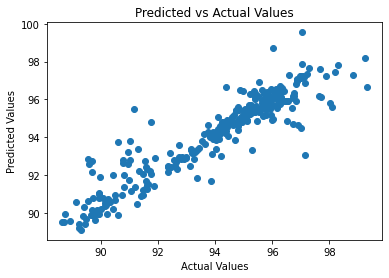

In [164]:
# Plot the predicted vs actual values
plt.scatter(test_set[:, -1], predictions)
plt.xlabel('Actual Values')

plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


In [165]:
# later, when you want to make predictions on new data
# load the encoders from the file
with open('encoders.pkl', 'rb') as f:
    le, le2, le3, le4 = pickle.load(f)

In [169]:
import datetime

n = 15 # number of rows
start_val = 1 # starting value for the fourth column
new_features = []
for i in range(n):
    row = ['PER', 1, 'HARD',1, start_val + i, 1, 1,'Race'] # create a new row with categorical variables as strings
    new_features.append(row) # add the row to the list

# create a DataFrame from the new data
new_data = pd.DataFrame(new_features, columns=['Driver','Stint','Compound','FreshTyre', 'TyreLife','TrackStatus','IsAccurate','Session'])

# encode the categorical variables using the saved encoders
compound_encoded = le.transform(new_data['Compound'].to_numpy())
#track_status_encoded = le2.transform(new_data['TrackStatus'].to_numpy())
session_encoded = le3.transform(new_data['Session'].to_numpy())
driver_encoded = le4.transform(new_data['Driver'].to_numpy())

# assign the encoded values back to the DataFrame
new_data['Compound'] = compound_encoded
#new_data['TrackStatus'] = track_status_encoded
new_data['Session'] = session_encoded
new_data['Driver'] = driver_encoded

predicted_lap_time_seconds = model.predict(new_data)
for i in range(n):
    #convert to datetime object
    time_obj = datetime.timedelta(seconds=predicted_lap_time_seconds[i])

    # convert to datetime object with an arbitrary date
    date_obj = datetime.datetime(2022, 1, 1) + time_obj

    # format the time string
    predicted_lap_time = date_obj.strftime('%M:%S.%f')[:-3]


    print(predicted_lap_time)


01:37.407
01:37.407
01:36.204
01:36.279
01:36.034
01:35.986
01:36.056
01:36.342
01:36.058
01:35.350
01:35.302
01:35.266
01:34.782
01:34.708
01:34.721


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


[datetime.timedelta(seconds=97, microseconds=407850), datetime.timedelta(seconds=97, microseconds=407850), datetime.timedelta(seconds=96, microseconds=204310), datetime.timedelta(seconds=96, microseconds=279920), datetime.timedelta(seconds=96, microseconds=34580), datetime.timedelta(seconds=95, microseconds=986270), datetime.timedelta(seconds=96, microseconds=56520), datetime.timedelta(seconds=96, microseconds=342050), datetime.timedelta(seconds=96, microseconds=58100), datetime.timedelta(seconds=95, microseconds=350830), datetime.timedelta(seconds=95, microseconds=302410), datetime.timedelta(seconds=95, microseconds=266740), datetime.timedelta(seconds=94, microseconds=782580), datetime.timedelta(seconds=94, microseconds=708440), datetime.timedelta(seconds=94, microseconds=721300)]
['1:37.408', '1:37.408', '1:36.204', '1:36.280', '1:36.035', '1:35.986', '1:36.057', '1:36.342', '1:36.058', '1:35.351', '1:35.302', '1:35.267', '1:34.783', '1:34.708', '1:34.721']
0:01:34.708440
0:01:37.407

<ipython-input-170-9d616100e4fc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_labels)


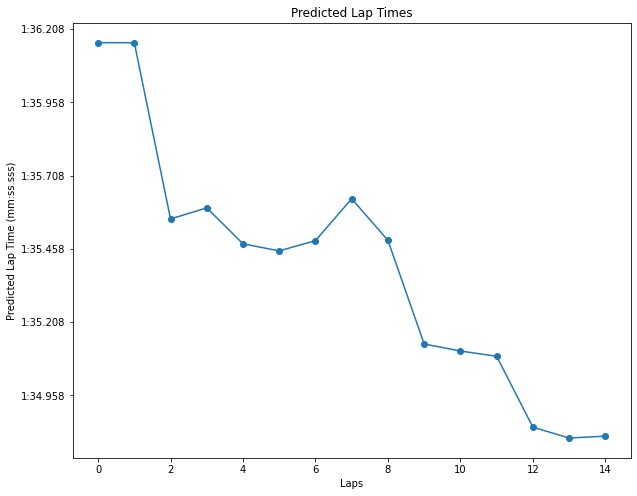

In [170]:
import datetime

# convert predicted lap times to datetime.timedelta objects
time_objs = [datetime.timedelta(seconds=t) for t in predicted_lap_time_seconds]
print(time_objs)

# convert to desired time format
predicted_lap_times = [f"{int(t.total_seconds() // 60):d}:{t.total_seconds() % 60:.3f}" for t in time_objs]
print(predicted_lap_times)

# calculate y-axis tick interval
time_interval = datetime.timedelta(seconds=0.25)
# set y-axis tick labels
min_time = min(time_objs)
print(min_time)

max_time = max(time_objs)
print(max_time)



tick_times = [min_time + n*time_interval for n in range(int((max_time-min_time)/time_interval)+1)]
print(tick_times)
tick_labels = [f"{int(t.total_seconds() // 60):d}:{t.total_seconds() % 60:.3f}" for t in tick_times]
print(tick_labels)
# create x values for the plot
x_values = range(len(predicted_lap_time_seconds))


# plot lap times
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x_values, predicted_lap_time_seconds, '-o')

ax.set_xlabel('Laps')
ax.set_ylabel('Predicted Lap Time (mm:ss.sss)')
ax.set_title('Predicted Lap Times')

#ax.set_yticks([(time_obj - min_time).total_seconds() for time_obj in tick_times])
ax.set_yticklabels(tick_labels)

plt.show()




In [172]:
import joblib

# save the model as a joblib file
joblib.dump(model, 'AI_Lap_Predictor.joblib')


['AI_Lap_Predictor.joblib']

In [ ]:
import joblib

# load the saved model from the joblib file
model = joblib.load('AI_Lap_Predictor.joblib')
# assume new data is saved in a variable called 'new_data'
model.fit(new_data)